#Supervised learning superstitions cheat sheet

This notebook contains my notes and beliefs about several commonly-used supervised learning algorithms. My dream is that it will be useful as a quick reference for people who are studying for machine learning interviews/quizzes/etc..


After some setup code, the methods discussed are:
+ Logistic regression
+ Decision trees
+ Support vector machines
+ K Nearest neighbors
+ Naive Bayes

To better understand each classifier we train on various versions of the "two moons" dataset and plot empirical decision boundaries. Each plot shows the training data on top of a few thousand randomly chosen points which have been colored by the output of the learned model. *Superstition #1:* The plots suggest that linear classifiers are often out performed on high quality training sets but still produce sane results on noisy small datasets. **Note: not all the plots have the same xy dimensions.** 

The code is available here: https://github.com/rcompton/ml_cheat_sheet

Other resources:
+ http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/ (good blog about choosing a classifier)
+ http://hunch.net/?p=22 (about overfitting)
+ http://www.dataschool.io/comparing-supervised-learning-algorithms/ (table of superstitions)
+ https://github.com/soulmachine/machine-learning-cheat-sheet (more like cheat 100 sheets)
+ http://scott.fortmann-roe.com/docs/BiasVariance.html (blog about the bias/variance problem)


In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
%pylab inline

#sklearn two moons generator makes lots of these...
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Populating the interactive namespace from numpy and matplotlib


In [2]:
"""
Build some datasets that I'll demo the models on
"""
Xs = []
ys = []

#low noise, plenty of samples, should be easy
X0, y0 = sklearn.datasets.make_moons(n_samples=1000, noise=.05)
Xs.append(X0)
ys.append(y0)

#more noise, plenty of samples
X1, y1 = sklearn.datasets.make_moons(n_samples=1000, noise=.3)
Xs.append(X1)
ys.append(y1)

#less noise, few samples
X2, y2 = sklearn.datasets.make_moons(n_samples=200, noise=.05)
Xs.append(X2)
ys.append(y2)

#more noise, less samples, should be hard
X3, y3 = sklearn.datasets.make_moons(n_samples=200, noise=.3)
Xs.append(X3)
ys.append(y3)

In [3]:
def plotter(model, X, Y, ax, npts=10000):
    """
    Simple way to get a visualization of the decision boundary 
    by applying the model to randomly-chosen points
    could alternately use sklearn's "decision_function"
    at some point it made sense to bring pandas into this
    """
    xs = []
    ys = []
    cs = []
    for _ in range(npts):
        x0spr = max(X[:,0])-min(X[:,0])
        x1spr = max(X[:,1])-min(X[:,1])
        x = np.random.rand()*x0spr + min(X[:,0])
        y = np.random.rand()*x1spr + min(X[:,1])
        xs.append(x)
        ys.append(y)
        cs.append(model.predict([x,y]))
    ax.scatter(xs,ys,c=cs, alpha=.35)
    ax.hold(True)
    ax.scatter(X[:,0],X[:,1],
                 c=list(map(lambda x:'r' if x else 'lime',Y)), 
                 linewidth=0,s=25,alpha=1)
    ax.set_xlim([min(X[:,0]), max(X[:,0])])
    ax.set_ylim([min(X[:,1]), max(X[:,1])])
    return

##Logistic Regression

Logistic regression is the canoncial example of a "discriminative" classifier (i.e. one that learns the mapping $f:X \rightarrow Y$ directly from the signal as opposed from learning a model of how the data was generated). Here, $Y$ is categorical and $X$ may be either continuous or categorical. A good short introduction (which also touches on generalized linear models) is [10].

Logistic regression assumes that $f$ is a sigmoid function of an inner product with the features, eg.

$$
P(Y=1 | X; \theta) = \sigma(\theta ^T X) = \frac{1}{1+exp(-\theta ^T X)}
$$

Training a logistic regression classifier amounts to learning the parameter vector, $\theta$. The most simple approach is via maximum liklihood estimation, i.e.:

\begin{eqnarray}
\theta^{MLE} &=& argmax_\theta \; \mathcal{L}(\theta)\\
 &=& argmax_\theta \; P(Y | X; \theta)\\
\end{eqnarray}

Now, in the special case where $Y$ can be only $0$ or $1$, the conditional density can be concisely written as

$$
P(Y | X; \theta) = \sigma(\theta ^T X)^Y (1-\sigma(\theta ^T X))^{1-Y}
$$

Assume the $M$ training examples were generated independently, we can thus write the likelihood as:

\begin{eqnarray}
\mathcal{L}(\theta) = \prod_i^M P(Y_i | X_i; \theta) 
\end{eqnarray}

It's easier to work with the log of the product, this leads to a convex unconstrained optimization:

$$
argmax_\theta = \sum_{i=1}^M \log(P(Y_i | X_i; \theta))
$$

**Remark:** Optimization problems tend to be stated as mins, so it's common to see this version to:

$$
argmin_\theta = \sum_{i=1}^M -\log(P(Y_i | X_i; \theta))
$$

The standard way solve this maximization is via [stochastic gradient ascent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). Usual gradient ascent involve an update rule over all of $\theta$, eg. $\theta^{next} = \theta + \alpha \nabla \mathcal{L}(\theta)$. If we have lots of training data computing the full gradient is slow. Stochastic gradient ascent means that we just compute the gradient in one (randomly-selected) direction before updating. The algorithm looks like this instead:

$$
\begin{align}
     1. & \mbox{Select a random ordering of the coordinates} \\
     2. & \mbox{while not converged:}\\
     & \quad    \mbox{for }i \in \{1, \ldots, M\}: \\
     & \qquad   \theta^{next} = \theta + \alpha \nabla_i \mathcal{L}(\theta)
\end{align}
$$

Unlike naive Bayes, logistic regression does not assume conditional independece (or any relation) between the features. As a result, when several extraneous features are provided, the MLE optimization can be solved by optimizing the irrelevant features (ie overfitting). The standard approach to reduce overfitting is to replace the MLE estimate with a MAP estime where a Laplacian prior, $P(\theta) = (\beta/2)^N exp(-\beta/|\theta|_1)$, has been assumed (the parameter $\beta$ is user-specified) [5]. The resulting minimization for such a MAP estimate is:

$$
argmin_\theta = \beta |\theta|_1 + \sum_{i=1}^M -\log(P(Y_i | X_i; \theta)
$$

Note the $L_1$ regularization. It favors a sparser $\theta$ (i.e. a simpler model (which is less prone to overfitting)) at the expense of a more difficult optimization problem.


###Pros:
+ Liblinear is usually available [1]
+ No user-defined parameters to experiment with unless you regularize (which you probably do), $\beta$ is intuitive
+ Fast to train
+ Fast to apply
+ You probably won't get fired for suggesting it
+ No assumptions about P(X|Y) during the learning stage (true of any discriminative method)
+ Logistic Regression is available in Spark [6]
+ Mark Tygert has done some writing about it [7]
+ Robust to outliers when compared against LDA (LDA assumes normal distributions in the density of the training data)


###Cons:
+ Often less accurate than the newer methods
+ Interpreting $\theta$ isn't straightforward
+ $L_1$ optimization is not easy
+ Bizarre use of the word "regression" until you learn about generalized linear models


###Neutral:
+ Parametric
+ Discriminative
+ Somehow equlivalent to neural networks with a single hidden layer
+ Somehow equlivalent to Gaussian naive Bayes


[1] http://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf

[2] https://www.cs.cmu.edu/~tom/mlbook/NBayesLogReg.pdf

[3] https://cs.stanford.edu/people/ang//papers/nips01-discriminativegenerative.pdf

[4] http://stackoverflow.com/questions/879432/what-is-the-difference-between-a-generative-and-discriminative-algorithm

[5] https://cs.stanford.edu/people/ang//papers/aaai06-efficientL1logisticregression.pdf

[6] https://spark.apache.org/docs/1.1.0/mllib-linear-methods.html

[7] http://www.cims.nyu.edu/~tygert/lr.pdf 

[8] http://math.arizona.edu/~hzhang/math574m/2014Lect6_LDAlog.pdf

[9] http://webdocs.cs.ualberta.ca/~greiner/C-466/SLIDES/3b-Regression.pdf

[10] http://cs229.stanford.edu/notes/cs229-notes1.pdf

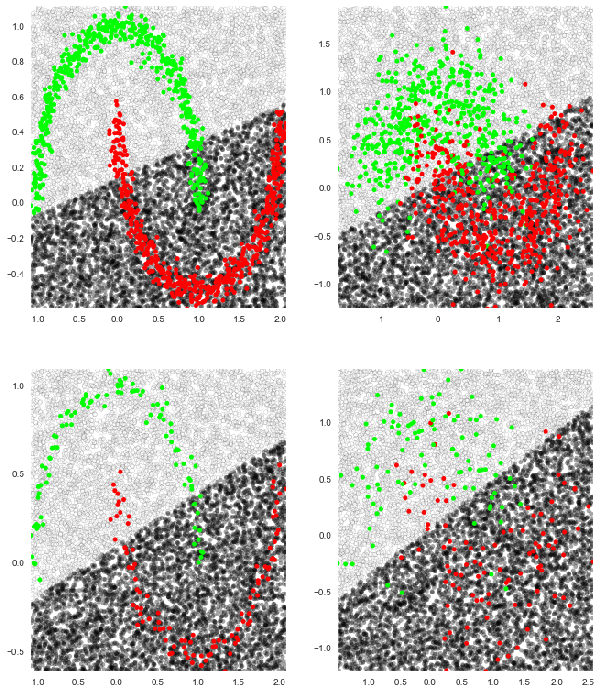

In [4]:
import sklearn.linear_model
classifier = sklearn.linear_model.LogisticRegression()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,13))
i=0
for X,y in zip(Xs,ys): 
    classifier.fit(X,y)
    plotter(classifier,X,y,ax=axes[i//2,i%2])
    i += 1
plt.show()

***

##Decision trees

Decision trees are opposite logistic regression in a few ways. Decision trees are nonlinear, nonparametric, and generate models which are simple to interpret (basically a flowchart). They perform well when given huge amounts of clean data and really shine when the data is not linearly-seperable. Decision trees are often used as an example of a method which is susceptible to overfitting (remark: neural networks are the other example).


####Basic idea to train via a greedy algorithm [6]:

1. Choose the best feature, $a^*$, for the root of the tree.
2. Divided training set, $S$, into subsets $\{S_1, S_2, \ldots ,S_k\}$ where the elements within each subset $S_i$ share the same value for $a^*$. (e.g. divide $[0,1]^2$ into $S_1$, $S_2$ where $S_1$ is points to the left of $x=0.5$ and $S_2$ contains points to the right_
3. Recursively apply this algorithm on each new subset until all examples have the same class label.

The resulting structure is a kd-tree. Applying the classifier to new points amounts to a standard nearest neighbor query.

Tall trees tend to indicate overfitting, pruning can help. Another way to reduce overfitting is to use a **random forest**. Random forest means training multiple decision trees and then building a classifier which applies all the trees to a datapoint and takes the mode of the predictions for the result. Two steps in random forest building [2]:

1. Inject randomness at the data level: build a "bagged forest" by training several trees, each one on altered labelings of your training data
2. Inject randomness at the model level: modify the tree learning algorithm such that at each candidate split only a random subset of features are considered in the division. Typlically, for $p$ features, $\sqrt{p}$ features are used in each split (cf wikipedia).

###Pros:
+ Simple to understand and to interpret. Trees can be visualised. [1]
+ Requires little data preparation (e.g. no data normalisation)
+ Able to handle both numerical and categorical data.
+ Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.
+ Works well when you have lots of data you don't understand. 

###Cons:
+ **Overfitting** (see bottom right plot)
+ Unstable - small variations in the data may lead to large variations in the tree
+ Finding the optimal decision tree (ie the smallest tree that minimizes training error) is NP-hard, so heuristics are always used
+ Unbalanced data leads to biased trees

###Neutral:
+ Decision trees rely on spatial data structures (i.e. kdtrees) which are complicated. However, Hanan's book has been around for a while so you never actually have to implement these things. [7]
+ The example of "low bias / high variance"
+ Difficult (but possible) to scale. Modern (like, 2015 modern) distributed learning tools have decision tree implementations [3] [4] [5].
+ Nonparametric
+ Discriminative


[1] http://scikit-learn.org/stable/modules/tree.html#tree

[2] http://blog.echen.me/2011/03/14/laymans-introduction-to-random-forests/

[3] https://mahout.apache.org/users/classification/partial-implementation.html

[4] https://spark.apache.org/docs/1.2.0/mllib-decision-tree.html

[5] https://static.googleusercontent.com/media/research.google.com/en/us/pubs/archive/36296.pdf

[6] http://web.engr.oregonstate.edu/~xfern/classes/cs534/notes/decision-tree-7-11.pdf

[7] https://www.cs.umd.edu/~hjs/design.html

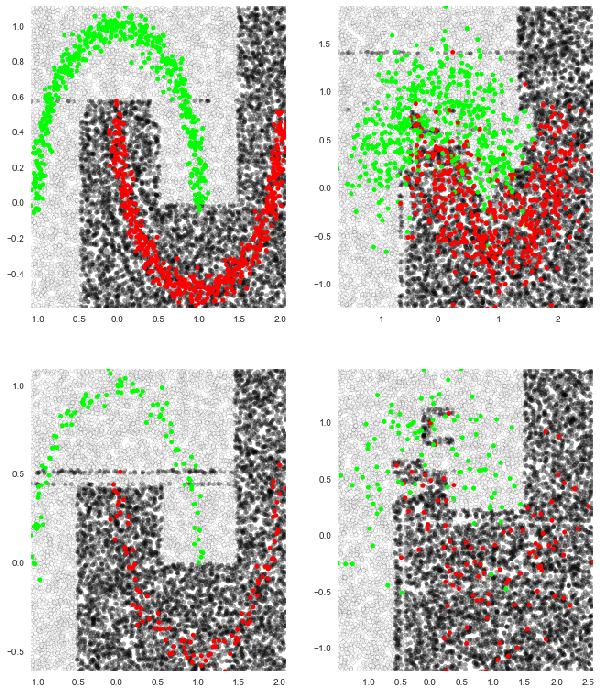

In [ ]:
import sklearn.tree
classifier = sklearn.tree.DecisionTreeClassifier()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,13))
i=0
for X,y in zip(Xs,ys): 
    classifier.fit(X,y)
    plotter(classifier,X,y,ax=axes[i//2,i%2])
    i += 1
plt.show()

***

## Support Vector Machines

Support vector machines are non-probabilistic discriminative linear classifiers. They work by finding the hyperplane that has the largest distance to the nearest training-data point of any class between two sets of points. With the commonly-used "kernel trick" (ie mapping all the points to a higher dimensional space (eg a sphere), finding the maximally-separating hyperplane in the high dimension, and then mapping back) they are able to identify nonlinear decision boundaries.

One-class support vector machines are useful to finds outliers or change point detection [3].

The (grossly oversimplified) idea follows. There exists a theory bound that says something along the lines of:

#####Test Error $\leq$ Training Error + Complexity of Model

where "Complexity of set of Models" means something about VC dimension [6]. Intuitively, a simple model drags down 2nd term but implies that training error is big, a complex model increases the 2nd term but reduces training error (ie "bounds on overfitting").

So, we want a model that minimizes the sum of the "training error" and the "complexity". Idea: learn a decision function, $f$, to solve

$$
min_f \sum_i label(f(x_i), y_i) + Complexity
$$

Use a separating hyperplane to figure $f$, ie $f(x_i) = \theta^T x_i + b$ (the "training error" term). Use a norm and a user-defined parameter to regularize, ie $C||\theta||_{1 or 2}$ (the "complexity" term). Note: some authors have found that an $L_1$ term makes the method less stable [1].

If linear is not enough, do the kernel trick: Represent all the points in a higher dimensional space (eg expaning to a basis of radial basis functions) and run the optimization in the high dimensional space.


###Pros:
+ Theoretical bounds on overfitting
+ Effective in high dimensional spaces (ie text).
+ Still effective in cases where number of dimensions is greater than the number of samples.
+ Can use a subset of training points in the decision function (called support vectors), to make it memory efficient.
+ libsvm is usually available
+ <http://www.kernel-machines.org> already exists



###Cons:
+ If the number of features is much greater than the number of samples, the method is likely to give poor performances.
+ SVMs do not directly provide probability estimates, though these can be calculated using an expensive five-fold cross-validation.
+ Selecting the wrong kernel may lead to bad results (ie really hard to tune)
+ Memory intensive unless you do something smart
+ Hard to interpret the model
+ To avoid overfitting you need spend lots of time tuning the regularization parameter

###Neutral:
+ They look nice on the two moons dataset
+ Distributed implementations exist [4]
+ Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. [2] [5]





[1] http://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf

[2] http://scikit-learn.org/stable/modules/svm.html

[3] https://rvlasveld.github.io/blog/2013/07/12/introduction-to-one-class-support-vector-machines/

[4] https://spark.apache.org/docs/latest/mllib-guide.html

[5] http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

[6] http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf

In [ ]:
import sklearn.svm
classifier = sklearn.svm.SVC()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,13))
i=0
for X,y in zip(Xs,ys): 
    classifier.fit(X,y)
    plotter(classifier,X,y,ax=axes[i//2,i%2])
    i += 1
plt.show()

***

##K nearest neighbors

"Nearest neighbor" is a dead simple non-parametric classifier which assigns to an unseen point, $x$, the value of the training point that it is closest to. "$K$ nearest neighbors" generalizes this idea to $K$ points, i.e. find the $K$ nearest training points to $x$ and use their majority vote to decide on a label for $x$. Larger $K$ leads to smoother decision boundaries.

###Pros:
+ Easy to explain
+ Learns nonlinear boundaries

###Cons:
+ Overfitting
+ Choice of $k$ is crucial
+ Must store all the training data
+ Need to decide on a good distance metric (Mahalanobis?)

###Neutral:
+ Need kd-trees (may be slow to apply in high dimensional space)
+ Much in common with locality sensitive hashing (can be used to speed up the search)
+ nonprobablistic
+ Low bias/high variance


[1] http://www.cs.ubc.ca/~murphyk/Teaching/CS340-Fall07/L4_knn.pdf

[2] https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/

[3] https://en.wikipedia.org/wiki/Locality-sensitive_hashing

[4] http://micvog.com/2013/09/08/storm-first-story-detection/

In [ ]:
import sklearn.neighbors
classifier = sklearn.neighbors.KNeighborsClassifier()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,13))
i=0
for X,y in zip(Xs,ys): 
    classifier.fit(X,y)
    plotter(classifier,X,y,ax=axes[i//2,i%2])
    i += 1
plt.show()

***

## Naive Bayes

Naive Bayes is the canonical example of a "generative" classifier, ie one that first learns a model for randomly generating the training data and then uses the learned probabilitity distributions to classify new points. There are several highly-cited comparisions between naive Bayes and logistic regression.

Deriving naive Bayes isn't completely insane. Just use Bayes rule to start, lump all the normalizations into a constant, and then invoke conditional independence. For example, to learn the probability of label $Y$ on feature $X=(X_0,...,X_N)$ you can do:

\begin{eqnarray}
P(Y=y_k|X) &=& \frac{P(Y=y_k)P(X|Y=y_k)}{P(X)}\\
&=& \frac{P(Y=y_k)P(X|Y=y_k)}{\sum_y P(X|Y=y)}\\
&=& \frac{P(Y=y_k)P(X_1 \ldots X_n|Y=y_k)}{\sum_y P(X_1 \ldots X_n|Y=y)}\\
&=& \frac{P(Y=y_k) \prod_iP(X_i|Y=y_k)}{\sum_y \prod_iP(X_i|Y=y)}
\end{eqnarray}

To make that 3rd equals sign work we needed to assume "conditional independence". From Wikipedia:

>R and B are conditionally independent given Y if and only if, given knowledge that Y occurs, knowledge of whether R occurs provides no information on the likelihood of B occurring, and knowledge of whether B occurs provides no information on the likelihood of R occurring.

Think of it like this: suppose you are building a classifier to identify if a particular tweet is about professional wrestling or a superhero movie. Given that a tweet is about wrestling, the knowledge that it contains the term "Hulk" provides no information on how likely it is to contain the term "Hollywood".

Computing the probabilities $P(X_i|Y=y)$ is where the "parametric" part of this comes into play. Typically one uses a Gaussian if the data is continuous and a Multinomial if the data is discrete (eg text). Here, the choice of priors plays the same role that choice of regularization plays in logistic regression.


###Pros:
+ Reliably a high bias/low variance classifier. Try it when you have noisy data, lots of features, and few samples
+ Handles extraneous featues well
+ Extremely fast to train/apply (just count things)
+ Famously good at document classification and spam filtering.[6]

###Cons:
+ Conditional independence is not always a valid assumption
+ Often outperformed by newer methods on high-quality data
+ When the feature set is large (and sparse, like word features in text classification) naive Bayes might "double count" features that are correlated with each other, because it assumes that each p(x|y) event is independent, when they are not. Logistic regression can do a better job by naturally "splitting the difference" among these correlated features.


###Neutral:
+ Parametric (nonparametric researchy versions exist, but usually one uses use GaussianNB (for continuous data) or MultinomialNB (for categorical data)
+ linear [4]
+ Gaussian Naive Bayes somehow reduces to Logistic Regression with an l2 regularization. 
+ *Remark:* An example of a generative clustering method is the "stochastic block model". [1]

[1] http://tuvalu.santafe.edu/~aaronc/courses/5352/fall2013/csci5352_2013_L16.pdf

[2] http://stackoverflow.com/questions/19129141/naive-bayes-and-logistic-regression-error-rate

[3] https://cs.stanford.edu/people/ang//papers/nips01-discriminativegenerative.pdf

[4] http://nlp.stanford.edu/IR-book/html/htmledition/linear-versus-nonlinear-classifiers-1.html

[5] http://scikit-learn.org/stable/modules/naive_bayes.html

[6] http://www.cs.unb.ca/profs/hzhang/publications/FLAIRS04ZhangH.pdf

[7] http://www.cs.colorado.edu/~jbg/teaching/DATA_DIGGING/lecture_05.pdf

In [ ]:
import sklearn.naive_bayes
classifier = sklearn.naive_bayes.GaussianNB()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,13))
i=0
for X,y in zip(Xs,ys): 
    classifier.fit(X,y)
    plotter(classifier,X,y,ax=axes[i//2,i%2])
    i += 1
plt.show()

In [ ]:
#without this the notebook is ~7MB
#https://pypi.python.org/pypi/ipynbcompress/0.3.0
import os
import ipynbcompress
filename = 'supervised_learning.ipynb'
print('before compress: {}'.format(os.stat(filename).st_size))
ipynbcompress.compress(filename, img_width=600, img_format='png')
print('after compress: {}'.format(os.stat(filename).st_size))